In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import statsmodels.api as sm
import sklearn
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the dataset 
real_state = pd.read_csv("train.csv")

In [3]:
# Let's take a look at the top rows 
real_state.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Checking null values in the columns 
real_state.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [5]:
# Taking a look at the dtypes of the columns
real_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Setting the Id column as index for easier operation on sub datasets and joining them later
real_state = real_state.set_index("Id")

In [7]:
# Selecting all the numerical datatypes in a separate dataframe
real_state_numeric = real_state.select_dtypes(include=["float64", "int64"])
real_state_numeric

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500


In [8]:
# Droping all the catagorical type data from the numerical dataset
real_state_numeric.drop(['MSSubClass','OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                              'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 
                                              'GarageCars', 'MoSold', 'YrSold', 'FullBath', 'HalfBath', 'Fireplaces', 
                                              'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'], axis=1, inplace=True)

In [9]:
# Taking a look at the numerical columns 
real_state_numeric

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,150,856,856,854,0,1710,548,0,61,0,0,0,0,0,208500
2,80.0,9600,0.0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,0,181500
3,68.0,11250,162.0,434,920,920,866,0,1786,608,0,42,0,0,0,0,0,223500
4,60.0,9550,0.0,540,756,961,756,0,1717,642,0,35,272,0,0,0,0,140000
5,84.0,14260,350.0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,7917,0.0,953,953,953,694,0,1647,460,0,40,0,0,0,0,0,175000
1457,85.0,13175,119.0,589,1542,2073,0,0,2073,500,349,0,0,0,0,0,0,210000
1458,66.0,9042,0.0,877,1152,1188,1152,0,2340,252,0,60,0,0,0,0,2500,266500


In [10]:
# Filling all the NaN values by 0 in numerical dataset 
real_state_numeric.fillna(0, inplace=True)
real_state_numeric

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,150,856,856,854,0,1710,548,0,61,0,0,0,0,0,208500
2,80.0,9600,0.0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,0,181500
3,68.0,11250,162.0,434,920,920,866,0,1786,608,0,42,0,0,0,0,0,223500
4,60.0,9550,0.0,540,756,961,756,0,1717,642,0,35,272,0,0,0,0,140000
5,84.0,14260,350.0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,7917,0.0,953,953,953,694,0,1647,460,0,40,0,0,0,0,0,175000
1457,85.0,13175,119.0,589,1542,2073,0,0,2073,500,349,0,0,0,0,0,0,210000
1458,66.0,9042,0.0,877,1152,1188,1152,0,2340,252,0,60,0,0,0,0,2500,266500


In [11]:
# Taking a final look at the numerical columns 
real_state_numeric.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

In [12]:
# Preparing the dataset for corrrlation map to check the correlation b/w the numerical data 
cor = real_state_numeric.corr()

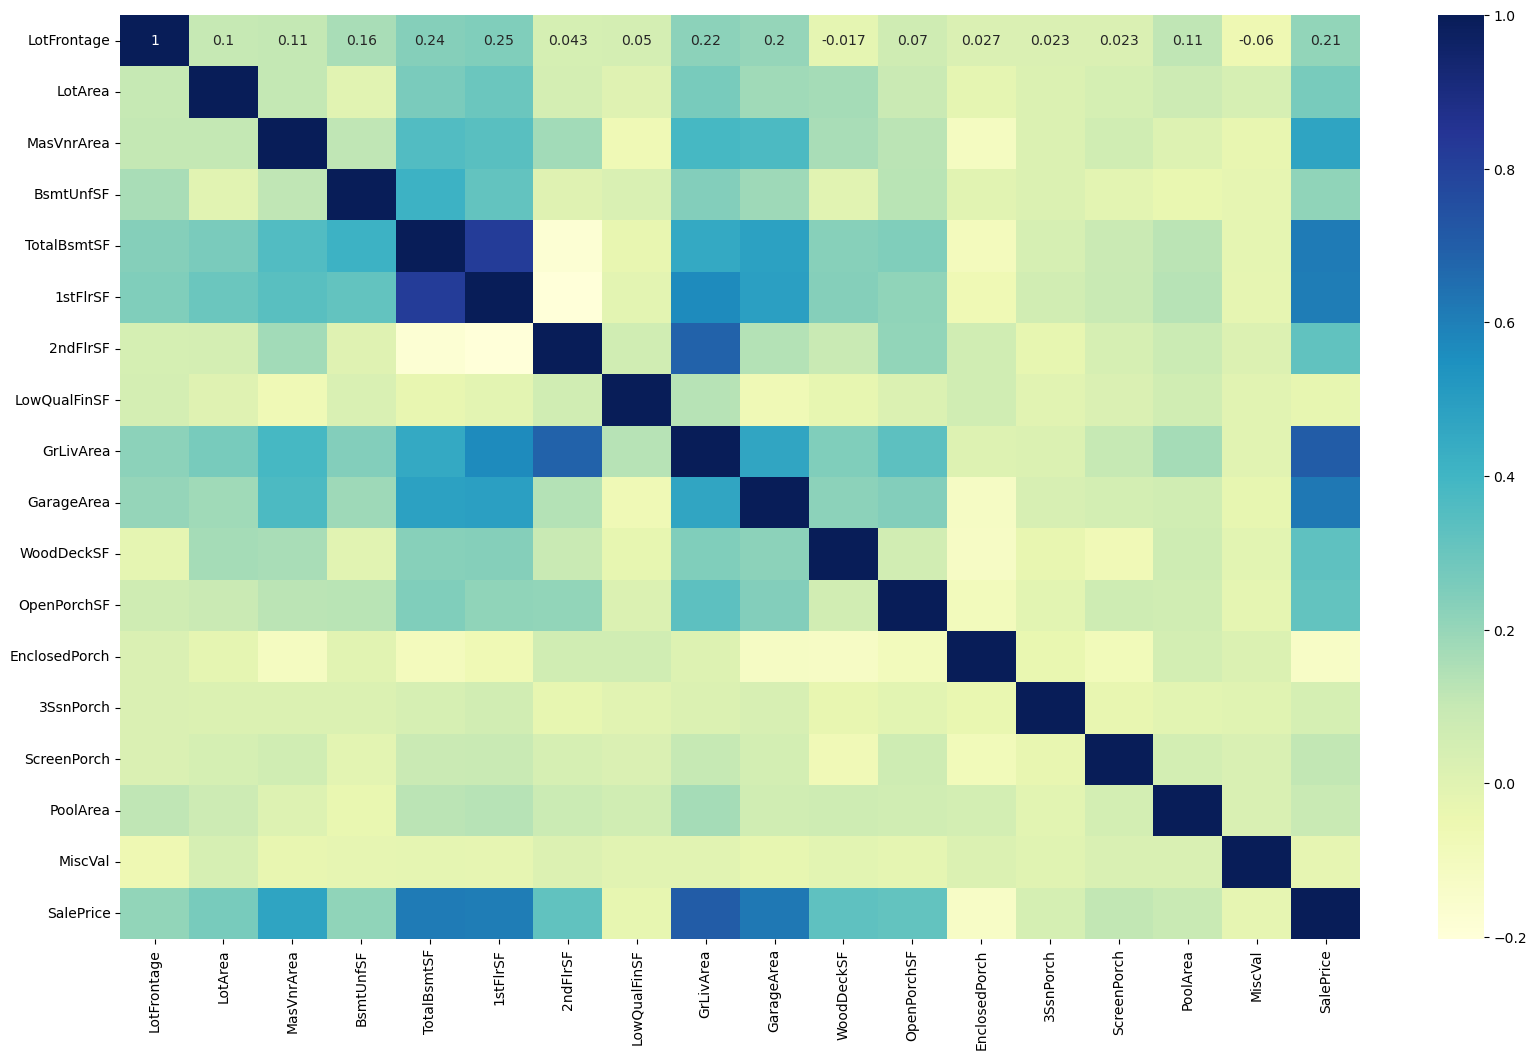

In [13]:
# Plotting the correlation map 
plt.figure(figsize=(20, 12))

sns.heatmap(cor,cmap="YlGnBu" , annot=True)
plt.show()

In [14]:
# Separating the categorical data which are integers types and changing their dtypes to object 
real_state_categorical_1 = real_state.loc[:, ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                              'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                                              'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces', 
                                              'GarageYrBlt','GarageCars', 'MoSold', 'YrSold']]
real_state_categorical_1 = real_state_categorical_1.astype("object")
real_state_categorical_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSSubClass    1460 non-null   object
 1   OverallQual   1460 non-null   object
 2   OverallCond   1460 non-null   object
 3   YearBuilt     1460 non-null   object
 4   YearRemodAdd  1460 non-null   object
 5   BsmtFinSF1    1460 non-null   object
 6   BsmtFinSF2    1460 non-null   object
 7   BsmtFullBath  1460 non-null   object
 8   BsmtHalfBath  1460 non-null   object
 9   FullBath      1460 non-null   object
 10  HalfBath      1460 non-null   object
 11  BedroomAbvGr  1460 non-null   object
 12  KitchenAbvGr  1460 non-null   object
 13  TotRmsAbvGrd  1460 non-null   object
 14  Fireplaces    1460 non-null   object
 15  GarageYrBlt   1379 non-null   object
 16  GarageCars    1460 non-null   object
 17  MoSold        1460 non-null   object
 18  YrSold        1460 non-null   object
dtypes: object(1

In [16]:
# checking the null values in the dataset
real_state_categorical_1.isnull().sum()

MSSubClass       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt     81
GarageCars       0
MoSold           0
YrSold           0
dtype: int64

In [17]:
# Changing the column GarageYrBlt to Int64 so as to change it again to object for easier manupulation 
real_state_categorical_1["GarageYrBlt"] = real_state_categorical_1["GarageYrBlt"].astype("Int64")
real_state_categorical_1 = real_state_categorical_1.astype("object")
real_state_categorical_1

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,
1,60,7,5,2003,2003,706,0,1,0,2,1,3,1,8,0,2003,2,2,2008
2,20,6,8,1976,1976,978,0,0,1,2,0,3,1,6,1,1976,2,5,2007
3,60,7,5,2001,2002,486,0,1,0,2,1,3,1,6,1,2001,2,9,2008
4,70,7,5,1915,1970,216,0,1,0,1,0,3,1,7,1,1998,3,2,2006
5,60,8,5,2000,2000,655,0,1,0,2,1,4,1,9,1,2000,3,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,6,5,1999,2000,0,0,0,0,2,1,3,1,7,1,1999,2,8,2007
1457,20,6,6,1978,1988,790,163,1,0,2,0,3,1,7,2,1978,2,2,2010
1458,70,7,9,1941,2006,275,0,0,0,2,0,4,1,9,2,1941,1,5,2010


In [18]:
# Selecting the remaining object type columns in a separate dataframe
real_state_categorical_2 = real_state.select_dtypes(include=["object"])
real_state_categorical_2

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


In [19]:
# Taking a look at the column names
real_state_categorical_2.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [20]:
# Checking for null values in the columns 
real_state_categorical_2.isnull().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [21]:
# All the values are categorical and getting dummy variables for them will convert their NaN values into 0, 
# so good to get dummy variables for them 
real_state_categorical_1_dummies = pd.get_dummies(~real_state_categorical_1, drop_first=True, dtype=int)
real_state_categorical_1_dummies

,MSSubClass_-181,MSSubClass_-161,MSSubClass_-121,MSSubClass_-91,MSSubClass_-86,MSSubClass_-81,MSSubClass_-76,MSSubClass_-71,MSSubClass_-61,MSSubClass_-51,...,MoSold_-7,MoSold_-6,MoSold_-5,MoSold_-4,MoSold_-3,MoSold_-2,YrSold_-2010,YrSold_-2009,YrSold_-2008,YrSold_-2007
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1458,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [22]:
# Getting dummy varibles for the conventional categorical column
real_state_categorical_2_dummies = pd.get_dummies(real_state_categorical_2, drop_first=True, dtype=int)
real_state_categorical_2_dummies

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1457,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1458,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [23]:
# Now merging all the sub dataframes into one dataframe
real_state_final = real_state_numeric.join([real_state_categorical_1_dummies, real_state_categorical_2_dummies])
real_state_final

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,150,856,856,854,0,1710,548,...,0,0,0,0,1,0,0,0,1,0
2,80.0,9600,0.0,284,1262,1262,0,0,1262,460,...,0,0,0,0,1,0,0,0,1,0
3,68.0,11250,162.0,434,920,920,866,0,1786,608,...,0,0,0,0,1,0,0,0,1,0
4,60.0,9550,0.0,540,756,961,756,0,1717,642,...,0,0,0,0,1,0,0,0,0,0
5,84.0,14260,350.0,490,1145,1145,1053,0,2198,836,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,7917,0.0,953,953,953,694,0,1647,460,...,0,0,0,0,1,0,0,0,1,0
1457,85.0,13175,119.0,589,1542,2073,0,0,2073,500,...,0,0,0,0,1,0,0,0,1,0
1458,66.0,9042,0.0,877,1152,1188,1152,0,2340,252,...,0,0,0,0,1,0,0,0,1,0


In [24]:
# Taking a look at all the columns
real_state_final.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=1356)

In [25]:
# Splitting into train and test data
df_train, df_test = train_test_split(real_state_final, train_size=0.7, test_size=0.3, random_state=100)

In [26]:
# Scaling all the train data
scaler = MinMaxScaler()
cols = df_train.columns
df_train = pd.DataFrame(scaler.fit_transform(df_train))
df_train.columns = cols
df_train

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.214058,0.019306,0.00000,0.169521,0.141408,0.113889,0.000000,0.000000,0.081860,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.287540,0.039403,0.16000,0.154110,0.220458,0.231481,0.616949,0.000000,0.424289,0.462623,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.166134,0.033981,0.00000,0.274401,0.120295,0.098611,0.333656,0.000000,0.201576,0.155148,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.188498,0.017931,0.00000,0.207620,0.079378,0.145602,0.307022,0.000000,0.230015,0.179831,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.191693,0.046139,0.00000,0.332620,0.127169,0.202315,0.505569,0.000000,0.355880,0.394922,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,0.191693,0.021158,0.00000,0.431507,0.164975,0.147222,0.000000,0.998058,0.208301,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017,0.201278,0.031445,0.00000,0.034247,0.119149,0.082407,0.352542,0.000000,0.195619,0.289140,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1018,0.217252,0.228257,0.00000,0.013699,0.301473,0.340278,0.000000,0.000000,0.269792,0.630465,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1019,0.217252,0.029672,0.22625,0.800086,0.305892,0.346528,0.000000,0.000000,0.274981,0.435120,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
# Splitting into dependent and independent variables i.e X and y
y_train = df_train.pop("SalePrice")
X_train = df_train

In [28]:
# Fitting a linear regression model and cheching their coefficient and intercept value
lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.intercept_)
print(lr.coef_)

0.004964467769475345
[ 0.05683795 -0.19023553  0.03886296 ... -0.0922114   0.01518029
  0.04531098]


In [29]:
# Fitting a statsmodels OLS model to check columns respective values,
# to get a better idea of the columns relation to dependent variable
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm)
res = lm.fit()
res.params

const                    0.002004
LotFrontage              0.056838
LotArea                 -0.190236
MasVnrArea               0.038863
BsmtUnfSF               -0.015794
                           ...   
SaleCondition_AdjLand    0.285519
SaleCondition_Alloca    -0.211068
SaleCondition_Family    -0.092211
SaleCondition_Normal     0.015180
SaleCondition_Partial    0.045317
Length: 1356, dtype: float64

In [30]:
# Getting the summary for better understanding of model Result
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     85.92
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           3.20e-08
Time:                        13:45:44   Log-Likelihood:                 5490.8
No. Observations:                1021   AIC:                            -8958.
Df Residuals:                       9   BIC:                            -3970.
Df Model:                        1011                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [31]:
# Making sure that both train and test data has columns in the same order
df_test.reindex(df_train.columns, axis=1)

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1437,60.0,9000,0.0,248,864,864,0,0,864,528,...,0,0,0,0,1,0,0,0,1,0
58,89.0,11645,0.0,860,860,860,860,0,1720,565,...,0,0,0,0,1,0,0,0,1,0
781,63.0,7875,38.0,1237,1237,1253,0,0,1253,402,...,0,0,0,0,1,0,0,0,1,0
383,79.0,9245,0.0,939,939,939,858,0,1797,639,...,0,0,0,0,1,0,0,0,1,0
1171,76.0,9880,0.0,574,1096,1118,0,0,1118,358,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,80.0,9600,132.0,50,1041,1041,0,0,1041,270,...,0,0,0,0,1,0,0,0,1,0
556,58.0,6380,0.0,993,993,1048,0,0,1048,280,...,0,0,0,0,1,0,0,0,1,0
400,65.0,8125,100.0,280,1092,1112,438,0,1550,438,...,0,0,0,0,1,0,0,0,1,0


In [32]:
# Scaling test data (only transform) for predictions
cols = df_test.columns
df_test = pd.DataFrame(scaler.transform(df_test))
df_test.columns = cols
df_test

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.191693,0.035192,0.00000,0.106164,0.141408,0.113889,0.000000,0.0,0.081860,0.372355,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.284345,0.047566,0.00000,0.368151,0.140753,0.112963,0.416465,0.0,0.246349,0.398449,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.201278,0.029930,0.02375,0.529538,0.202455,0.203935,0.000000,0.0,0.156610,0.283498,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.252396,0.036338,0.00000,0.401969,0.153682,0.131250,0.415496,0.0,0.261145,0.450635,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.242812,0.039309,0.00000,0.245719,0.179378,0.172685,0.000000,0.0,0.130669,0.252468,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,0.255591,0.037999,0.08250,0.021404,0.170376,0.154861,0.000000,0.0,0.115872,0.190409,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
434,0.185304,0.022936,0.00000,0.425086,0.162520,0.156481,0.000000,0.0,0.117218,0.197461,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
435,0.207668,0.031099,0.06250,0.119863,0.178723,0.171296,0.212107,0.0,0.213682,0.308886,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
436,0.000000,0.057820,0.11125,0.000000,0.197054,0.232639,0.390315,0.0,0.335319,0.554302,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [33]:
# Splitting the test data into independent and dependent variables
y_test = df_test.pop("SalePrice")
X_test = df_test

In [34]:
# Getting ready for building Ridge and Lasso models
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [35]:
# Apllying Ridge Regression including regularization
ridge = Ridge()
folds = 5

model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [36]:
# Cheking its result in a Dataframe
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.176543,0.026290,0.442250,0.138489,0.0001,{'alpha': 0.0001},-0.071604,-0.069842,-0.072681,-0.071727,...,-0.069310,0.004403,28,-0.000060,-0.000043,-0.000057,-0.000066,-0.000051,-0.000055,0.000008
1,1.228062,0.120462,0.362529,0.006260,0.001,{'alpha': 0.001},-0.062375,-0.061902,-0.060336,-0.057517,...,-0.058194,0.004975,27,-0.000322,-0.000261,-0.000256,-0.000334,-0.000284,-0.000292,0.000031
2,1.238073,0.067246,0.444309,0.130972,0.01,{'alpha': 0.01},-0.045567,-0.048800,-0.048331,-0.046587,...,-0.045625,0.003588,25,-0.001365,-0.001144,-0.001068,-0.001282,-0.001089,-0.001190,0.000115
3,1.238666,0.175227,0.367917,0.011008,0.05,{'alpha': 0.05},-0.036444,-0.040297,-0.039543,-0.039663,...,-0.037897,0.002558,23,-0.003141,-0.002674,-0.002663,-0.002974,-0.002646,-0.002820,0.000202
4,1.468821,0.288644,0.500810,0.213026,0.1,{'alpha': 0.1},-0.034245,-0.036979,-0.036292,-0.036989,...,-0.035270,0.001985,22,-0.004317,-0.003741,-0.003869,-0.004176,-0.003787,-0.003978,0.000227


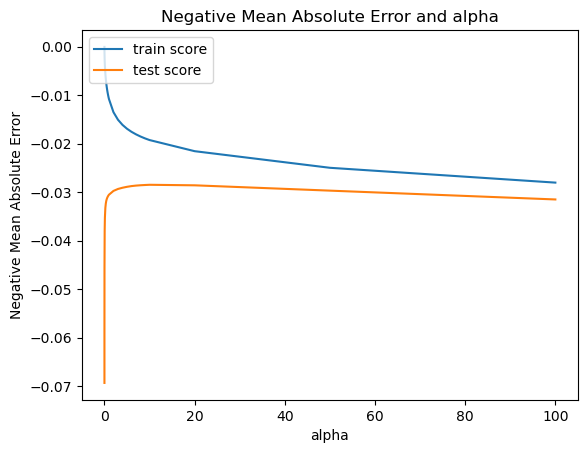

In [37]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha']

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [44]:
# Applying best parameter to Ridge and getting the coeffient
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 0.07323736, -0.10273739,  0.06469253, ..., -0.01153471,
       -0.00490417,  0.01632251])

In [46]:
# Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 
model_cv.best_params_()

Fitting 5 folds for each of 28 candidates, totalling 140 fits


TypeError: 'dict' object is not callable

In [ ]:
# Checking result in a dataframe
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

In [ ]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [ ]:
alpha = 10

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

In [ ]:
lasso.coef_